In [5]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

import os
import renaissance.helper as hp
from configparser import ConfigParser

from renaissance.kinetics.jacobian_solver import check_jacobian
from renaissance.ppo_refinement import PPORefinement

# Train PPO agent

In [2]:
#Parse arguments from configfile
configs = ConfigParser()
configs.read('configfile.ini')

n_samples = int(configs['MLP']['n_samples']) # Used by MLP for its internal sampling if any, and for p0 generation.

lnminkm = float(configs['CONSTRAINTS']['min_km'])
lnmaxkm = float(configs['CONSTRAINTS']['max_km'])

repeats = int(configs['EVOSTRAT']['repeats'])
generations = int(configs['EVOSTRAT']['generations']) # Will be used as num_iterations for PPO
ss_idx = int(configs['EVOSTRAT']['ss_idx'])
# n_threads = int(configs['EVOSTRAT']['n_threads']) # PPO collection is currently single-threaded

output_path = configs['PATHS']['output_path']
met_model = configs['PATHS']['met_model']
names_km_config = hp.load_pkl(f'models/{met_model}/parameter_names_km_fdp1.pkl') # Full list of param names

# Parameters needed directly by PPORefinement
param_dim_config = int(configs['MLP']['no_kms'])
latent_dim_config = int(configs['MLP']['latent_dim']) # For z vector in state


# Call solvers from SKimPy (Used only for initial messages now)
chk_jcbn = check_jacobian()

In [3]:
# Integrate data
print('---- Load kinetic and thermodynamic data')
chk_jcbn._load_ktmodels(met_model, 'fdp1')           ## Load kinetic and thermodynamic data
print('---- Load steady state data')
chk_jcbn._load_ssprofile(met_model, 'fdp1', ss_idx)  ## Integrate steady state information

---- Load kinetic and thermodynamic data


2025-05-15 13:55:40,872 - thermomodel_new - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2025-05-15 13:55:42,338 - Unnamed - WARNING - Non integer stoichiometries found ['CYTBO3_4pp', 'LMPD_biomass_c_1_420', 'CYTBDpp'] change to integer for linear dependencies
2025-05-15 13:55:42,627 - Unnamed - WARNING - Non integer stoichiometries found ['CYTBO3_4pp', 'LMPD_biomass_c_1_420', 'CYTBDpp'] change to integer for linear dependencies


---- Load steady state data


In [4]:
lambda_partition = -2.5
reward_flag = 0

def _get_lambda_max(p_tensor_single):
    p_numpy = p_tensor_single.detach().cpu().numpy()
    # Use the stored chk_jcbn instance
    chk_jcbn._prepare_parameters([p_numpy], names_km_config) 
    max_eig_list = chk_jcbn.calc_eigenvalues_recal_vmax()
    max_eig_list.sort()

    return max_eig_list

def compute_reward(p_tensor_single, n_consider=10):
    lambdas_val = _get_lambda_max(p_tensor_single)

    if reward_flag == 0:
        lambda_max_val = lambdas_val[0]
        penalty = np.maximum(0, lambda_max_val)
        if lambda_max_val > 100:
            lambda_max_val = 100
        r = 1.0 / (1.0 + np.exp(lambda_max_val - lambda_partition))
        r -= penalty
    else:
        considered_avg = sum(lambdas_val[:n_consider]) / n_consider
        r = np.exp(-0.1 * considered_avg) / 2
    # TODO: Right now, we are not using the Incidence part of the reward.

    return r


In [ ]:
print('--- Begin PPO refinement strategy')

this_savepath = f'{output_path}/ppo/' 
os.makedirs(this_savepath, exist_ok=True)

ppo_agent = PPORefinement(
    param_dim=param_dim_config,
    noise_dim=latent_dim_config,
    reward_function=compute_reward,
    min_x_bounds=lnminkm,
    max_x_bounds=lnmaxkm,
    ppo_epochs=10,
    T_horizon=10,
    actor_lr=1e-5,
    critic_lr=5e-5,
    n_trajectories=256
)

trained_actor, rewards = ppo_agent.train(num_training_iterations=100, output_path=this_savepath)

print(f"PPO training finished. Rewards log saved to {this_savepath}")


--- Begin PPO refinement strategy
Training on cpu. 256 trajectories per update.
Iteration 1/100, Avg Batch Final Reward: -196.9942
Avg actor loss 0.0133 Avg critic loss 1875300.3250


In [ ]:
def evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50):
    T_HORIZON = ppo_agent.T_horizon
    NOISE_DIM = ppo_agent.noise_dim
    N_TRIALS = num_trials
    incidence = 0
    for _ in range(N_TRIALS):
        current_params_in_state = ppo_agent._initialize_current_params_for_state().clone()
        generated_sequence = []
        for _ in range(T_HORIZON):
            noise = torch.randn(NOISE_DIM, device=ppo_agent.device)
            state_1d = torch.cat((noise, current_params_in_state.detach()), dim=0)
            state_batch = state_1d.unsqueeze(0)
            with torch.no_grad():
                mu_raw, log_std_raw = trained_actor(state_batch)
                # For generation, you might want to take the mean (mu_raw) or sample
                # action_raw = mu_raw # Deterministic generation
                action_raw = Normal(mu_raw, torch.exp(log_std_raw)).sample() # Stochastic generation
            
            ode_params = ppo_agent._transform_to_bounded(action_raw)
            current_params_in_state = ode_params.squeeze(0)
            generated_sequence.append(current_params_in_state.cpu().numpy())

        final_generated_params = generated_sequence[-1]
        final_reward_eval = compute_reward(torch.tensor(final_generated_params, device=ppo_agent.device))
        lambda_max = _get_lambda_max(torch.tensor(final_generated_params, device=ppo_agent.device))[0]
        if lambda_max < -2.5:
            incidence += 1
        print(f"Final lambda_max: {lambda_max:.4f}")
        print(f"Final reward: {final_reward_eval:.4f}")
    print(f"Incidence over {N_TRIALS} trials: {incidence}/{N_TRIALS} = {incidence/N_TRIALS:.2f}")


In [ ]:
evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50)

Final lambda_max: 69.4703
Final reward: -69.4703
Final lambda_max: 73.0140
Final reward: -73.0140
Final lambda_max: 72.2073
Final reward: -72.2073
Final lambda_max: 69.2726
Final reward: -69.2726
Final lambda_max: 69.0081
Final reward: -69.0081
Final lambda_max: 69.3999
Final reward: -69.3999
Final lambda_max: 73.5059
Final reward: -73.5059
Final lambda_max: 74.9172
Final reward: -74.9172
Final lambda_max: 67.6325
Final reward: -67.6325
Final lambda_max: 66.7483
Final reward: -66.7483
Final lambda_max: 69.9099
Final reward: -69.9099
Final lambda_max: 66.9351
Final reward: -66.9351
Final lambda_max: 69.5804
Final reward: -69.5804
Final lambda_max: 68.9582
Final reward: -68.9582
Final lambda_max: 69.6110
Final reward: -69.6110
Final lambda_max: 70.0161
Final reward: -70.0161
Final lambda_max: 68.8618
Final reward: -68.8618
Final lambda_max: 67.1279
Final reward: -67.1279
Final lambda_max: 71.2430
Final reward: -71.2430
Final lambda_max: 70.7899
Final reward: -70.7899
Final lambda_max: 69

In [10]:
this_savepath

'output/ppo-refinement//ppo/'

In [ ]:
os.listdir("output/ppo-refini")

['ppo-refinement']

In [13]:
# load results
path = "output/ppo-refinement/ppo_repeat_0/ppo_iteration_rewards.pkl"
rewards = np.load(path, allow_pickle=True)

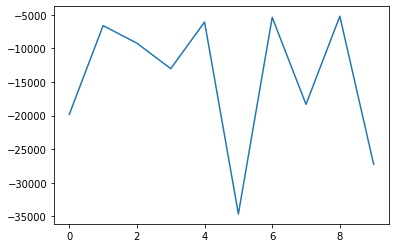

In [14]:
plt.plot(rewards)